# Bayesian Machine Learning

https://medium.com/@brechterlaurin/putting-bayesian-models-into-production-1efae307a138

<br>

***

<br>

## Import Libraries

In [1]:
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pytensor.tensor as at

print(f"PYMC Version {pm.__version__}")

PYMC Version 5.15.0


<br>

***

<Br>

## Prep Data

In [2]:
# !kaggle datasets download -d nikhil7280/student-performance-multiple-linear-regression

# # Define the path to the downloaded zip file
# zip_file_path = 'student-performance-multiple-linear-regression.zip'

# # Define the directory to extract the contents
# extract_dir = 'student_performance_data'

# # Create the directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract the contents of the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f'Dataset extracted to {extract_dir}')

df = pd.read_csv('C:\\Users\\wallj\\DS_Projects\\Bayesian_Inference\\pymc_code\\student_performance_data\\Student_Performance.csv')
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0


In [3]:
# Tell me about the data, what are the features?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [4]:
# Are there any null values in the dataset?
df.isna().any()

Hours Studied                       False
Previous Scores                     False
Extracurricular Activities          False
Sleep Hours                         False
Sample Question Papers Practiced    False
Performance Index                   False
dtype: bool

## Examine Features Individually

In [5]:
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
No     5052
Yes    4948
Name: count, dtype: int64

In [6]:
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])
df['Extracurricular Activities'].value_counts(dropna=False)

Extracurricular Activities
0    5052
1    4948
Name: count, dtype: int64

In [7]:
df["Hours Studied"].value_counts(dropna=False)

Hours Studied
1    1152
6    1133
7    1129
3    1119
9    1115
5    1094
8    1088
4    1085
2    1085
Name: count, dtype: int64

In [8]:
df["Previous Scores"].describe()

count    10000.000000
mean        69.445700
std         17.343152
min         40.000000
25%         54.000000
50%         69.000000
75%         85.000000
max         99.000000
Name: Previous Scores, dtype: float64

In [9]:
df["Sleep Hours"].value_counts(dropna=False)

Sleep Hours
8    1804
7    1676
6    1673
9    1622
4    1619
5    1606
Name: count, dtype: int64

In [10]:
df["Sample Question Papers Practiced"].value_counts(dropna=False)

Sample Question Papers Practiced
6    1059
9    1051
3    1035
5    1028
8    1026
7     987
1     978
4     955
0     951
2     930
Name: count, dtype: int64

## Examine Target Feature Specifically

In [11]:
# df = df[~df.duplicated()]
# df = df.dropna().astype(float)
# columns = df.columns.values[:-1] 
df = df.astype(float)

In [12]:
df["Performance Index"].describe()

count    10000.000000
mean        55.224800
std         19.212558
min         10.000000
25%         40.000000
50%         55.000000
75%         71.000000
max        100.000000
Name: Performance Index, dtype: float64

In [13]:
# Create target variables
df['Pass Fail'] = df['Performance Index'].apply(lambda x: 1 if x >= 50 else 0)
y_lin = df['Performance Index']
y_log = df['Pass Fail']
y_lin = y_lin.astype(float)
y_log = y_log.astype(float)


X = df.drop(columns=['Performance Index', 'Pass Fail'])
X = X.astype(float)

df['Pass Fail'].value_counts(dropna=False)

Pass Fail
1    5909
0    4091
Name: count, dtype: int64

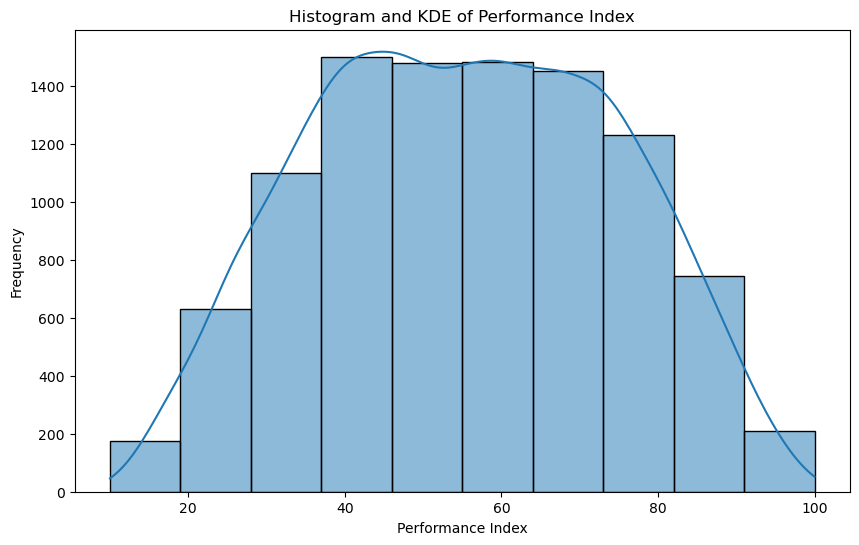

In [14]:
# Histogram & KDE plot of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Performance Index'], kde=True, bins=10)
plt.title('Histogram and KDE of Performance Index')
plt.xlabel('Performance Index')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Sample Quantiles')

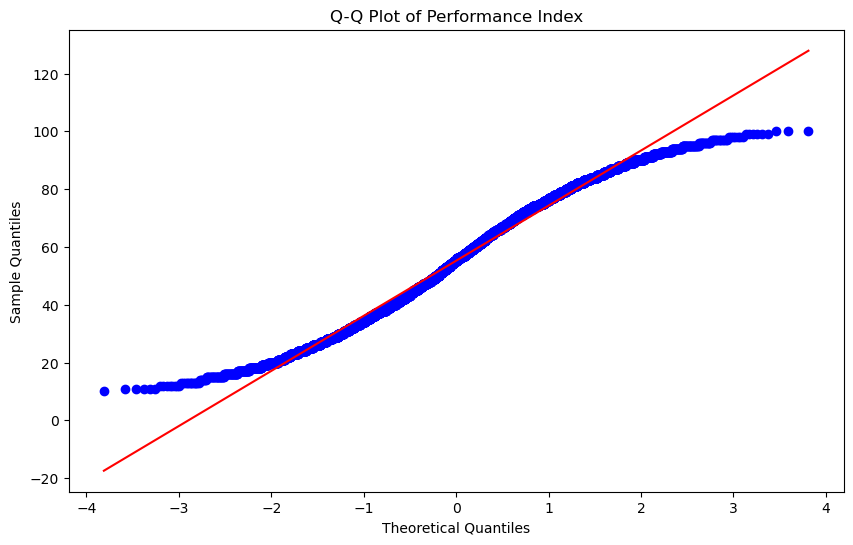

In [15]:
# QQ Plot for Target
plt.figure(figsize=(10, 6))
stats.probplot(df['Performance Index'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Performance Index')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

## Train Test Split

In [16]:
# Since we're doing prediction, we will need to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_lin, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (8000, 5)
X_test shape: (2000, 5)


## Standardize Features

In [17]:
# ==================================================== #
# Optional to Standardize Variables                    #
# ==================================================== #

# pros: sampling efficiency (NUTS), numerical stability (MCMC), you can transform back to normal at the end (or not - interpret the standard deviation)
# x_norm = (x - x.mean()) / x.s"td() # x was created above!

# Standardize the features
X_train_scaled = (X_train - X_train.mean()) / X_train.std()
y_train_scaled = (y_train - y_train.mean()) / y_train.std()

# Standardize the test set
X_test_scaled = (X_test - X_train.mean()) / X_train.std()
y_test_scaled = (y_test - y_train.mean()) / y_train.std()

# Convert scaled features to tensors
X_train_input = pm.floatX(X_train_scaled)
y_train_input = pm.floatX(y_train_scaled)

# Convert scaled test set to tensors
X_test_input = pm.floatX(X_test_scaled)
y_test_input = pm.floatX(y_test_scaled)

## Build Model in PYMC

In [ ]:
with pm.Model() as pymc_pred_model:
    # Convert specific columns to shared tensors
    hours_studied = pm.Data('hours_studied', X_train_input['Hours Studied'].values)
    prev_scores = pm.Data('prev_scores', X_train_input['Previous Scores'].values)
    extra_activities = pm.Data('extra_activities', X_train_input['Extracurricular Activities'].values)
    sleep_hours = pm.Data('sleep_hours', X_train_input['Sleep Hours'].values)
    sample_papers = pm.Data('sample_papers', X_train_input['Sample Question Papers Practiced'].values)

    # Priors
    beta_hours = pm.Normal('beta_hours', mu=0, sigma=10)
    beta_prev_scores = pm.Normal('beta_prev_scores', mu=0, sigma=10)
    beta_extra = pm.Normal('beta_extra', mu=0, sigma=10)
    beta_sleep = pm.Normal('beta_sleep', mu=0, sigma=10)
    beta_sample = pm.Normal('beta_sample', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        intercept
        + beta_hours * hours_studied
        + beta_prev_scores * prev_scores
        + beta_extra * extra_activities
        + beta_sleep * sleep_hours
        + beta_sample * sample_papers
    )

    # Likelihood
    performance = pm.Normal('performance', mu=mu, sigma=sigma, observed=y_train_input.values, dims='obs_id')

    # Sample posterior
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_hours, beta_prev_scores, beta_extra, beta_sleep, beta_sample, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


## Model Diagnostics

### Plot Posterior

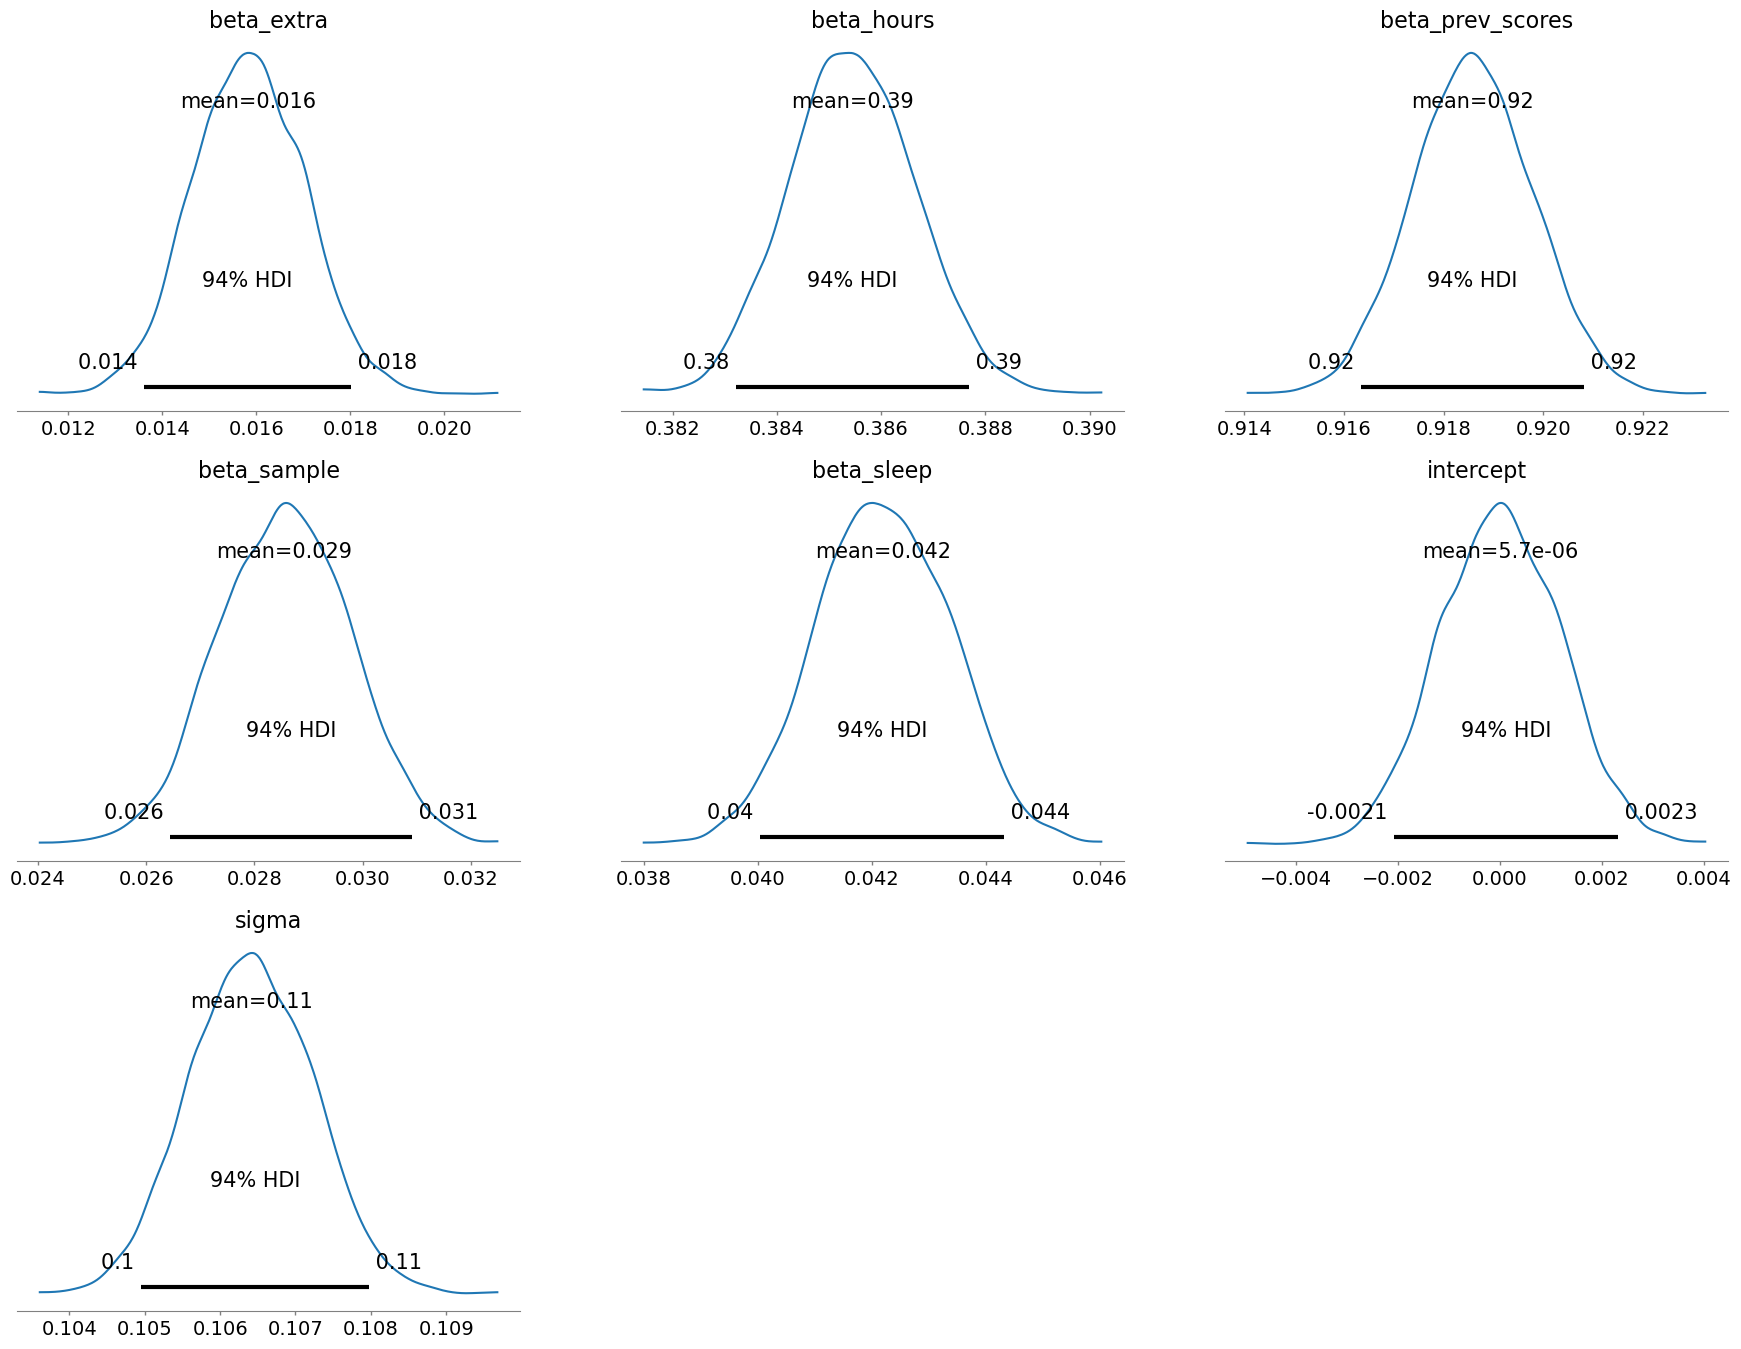

In [81]:
az.plot_posterior(trace);

### Model to Graphviz

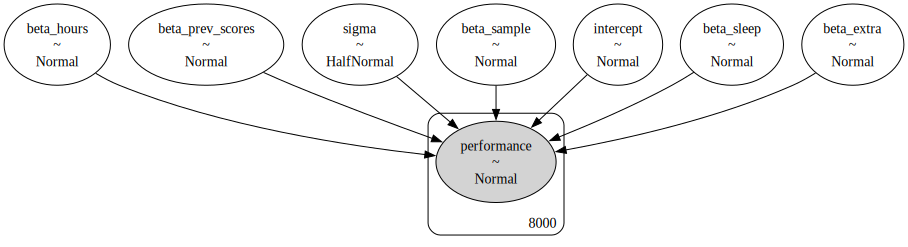

In [83]:
pm.model_to_graphviz(pymc_pred_model)

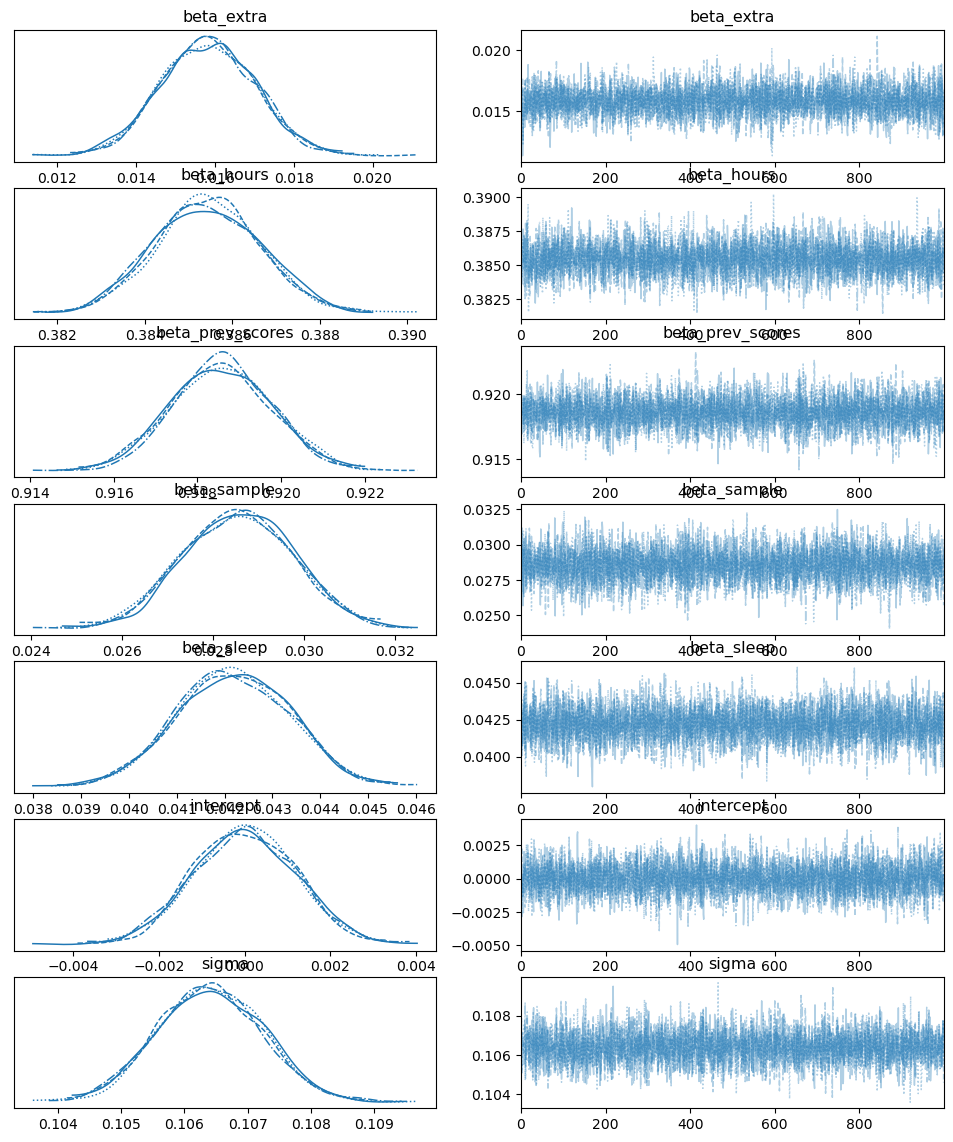

In [86]:
# Visualize trace
az.plot_trace(trace);
plt.show();

In [88]:
# Summary of the posterior distributions
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_extra,0.016,0.001,0.014,0.018,0.0,0.0,5553.0,3345.0,1.0
beta_hours,0.385,0.001,0.383,0.388,0.0,0.0,5450.0,3517.0,1.0
beta_prev_scores,0.919,0.001,0.916,0.921,0.0,0.0,6009.0,3386.0,1.0
beta_sample,0.029,0.001,0.026,0.031,0.0,0.0,5338.0,3287.0,1.0
beta_sleep,0.042,0.001,0.040,0.044,0.0,0.0,5188.0,3360.0,1.0
intercept,0.000,0.001,-0.002,0.002,0.0,0.0,6458.0,3236.0,1.0
sigma,0.106,0.001,0.105,0.108,0.0,0.0,5287.0,3100.0,1.0


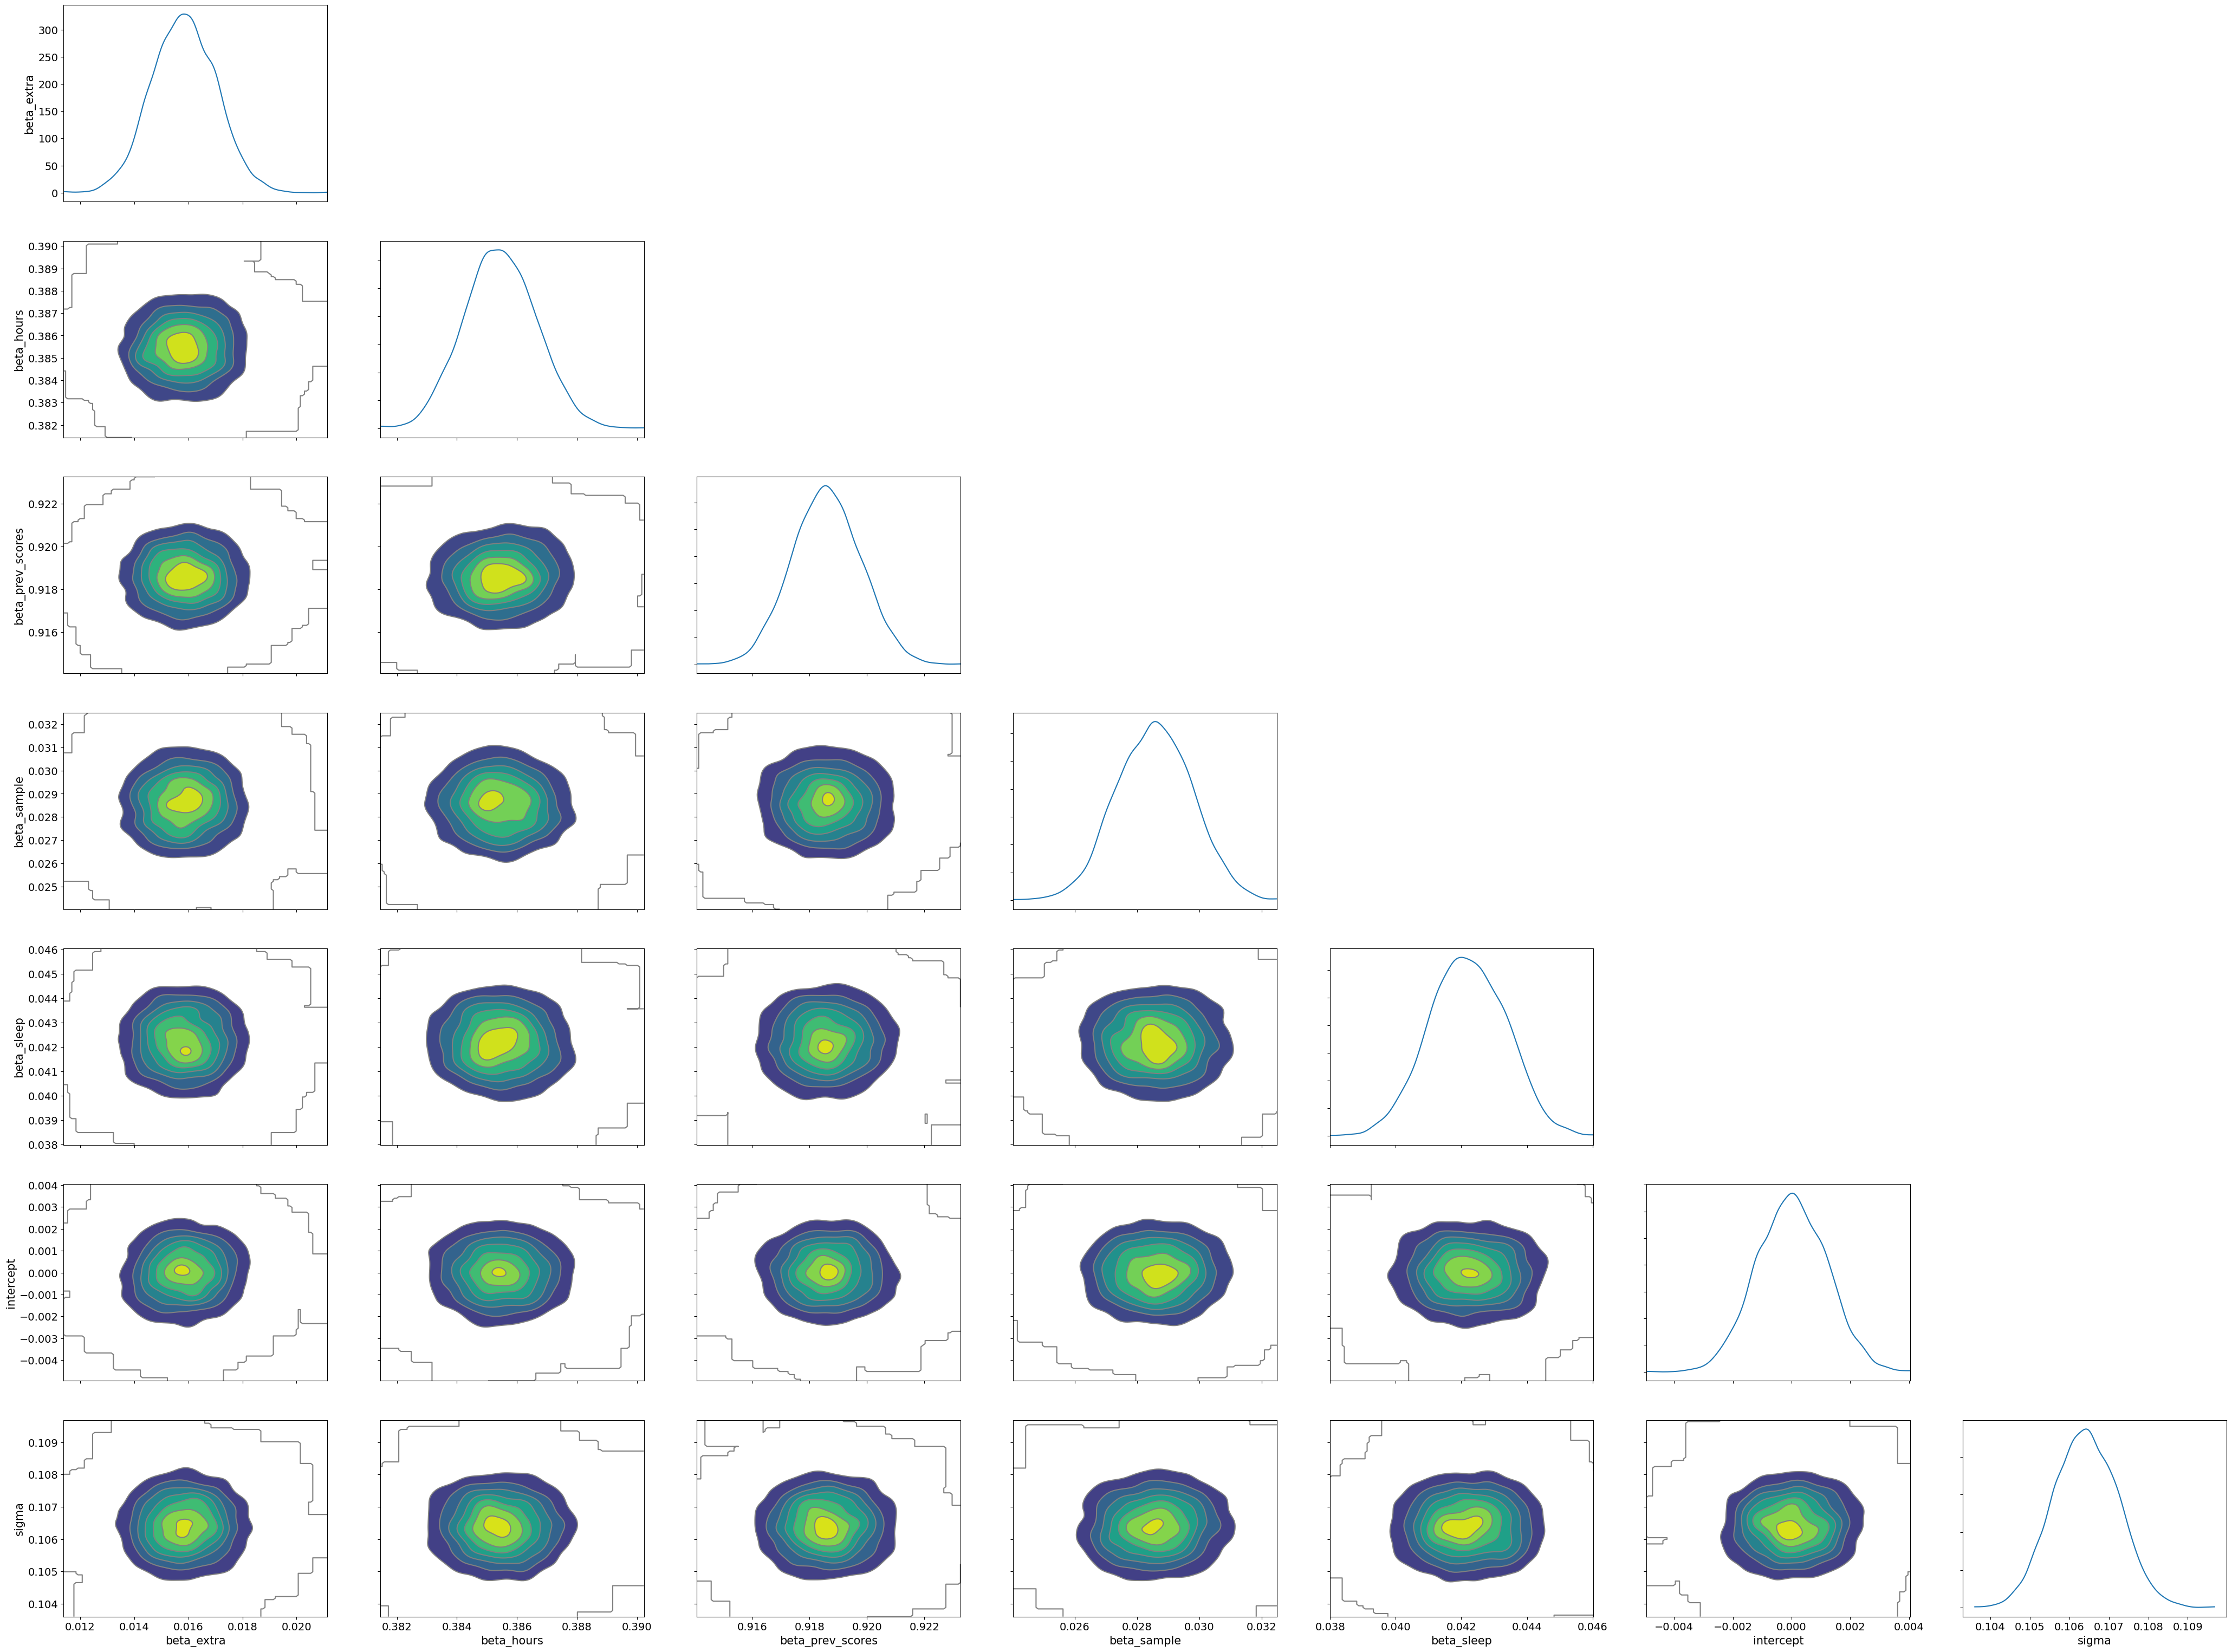

In [89]:
# Pair Plot
az.plot_pair(trace, kind="kde", marginals=True);

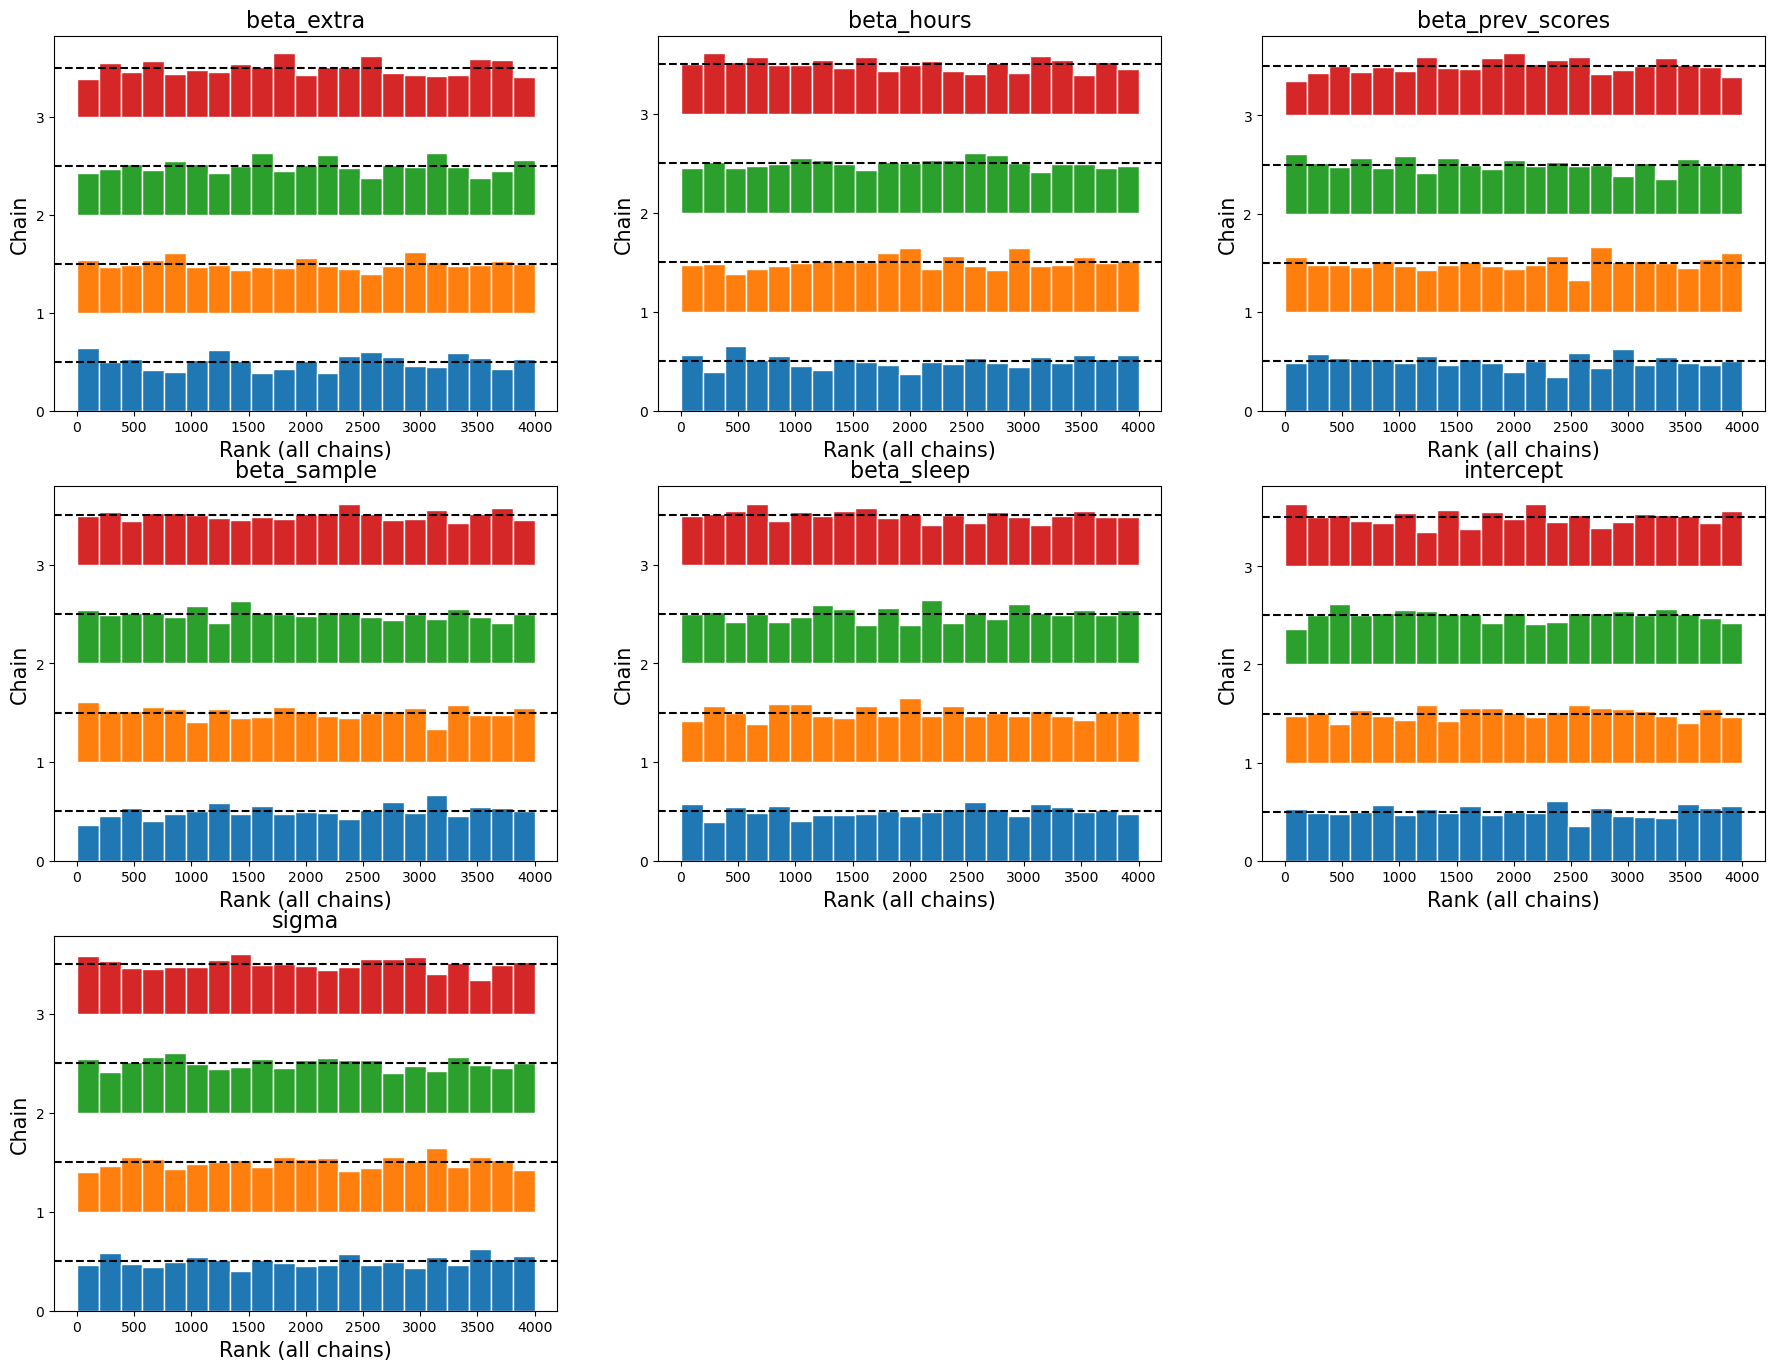

In [90]:
# Rank Plot
az.plot_rank(trace);
plt.show();

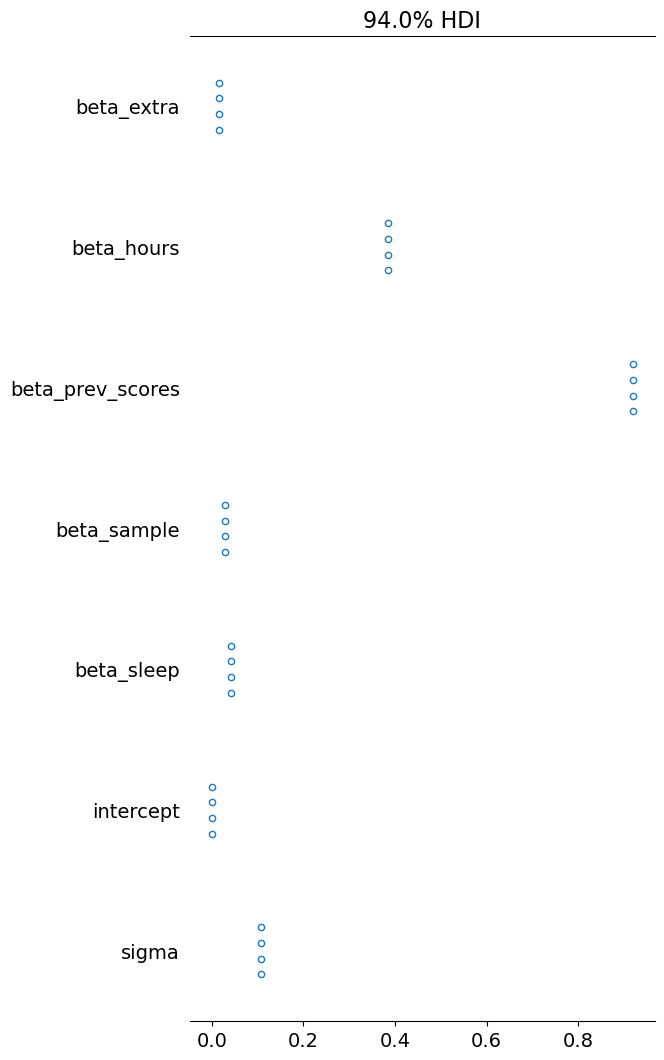

In [91]:
# Posterior Interval Plot
az.plot_forest(trace);

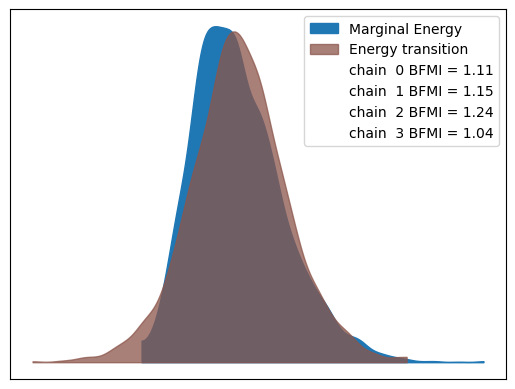

In [92]:
# Engery Plot
az.plot_energy(trace)
plt.show()

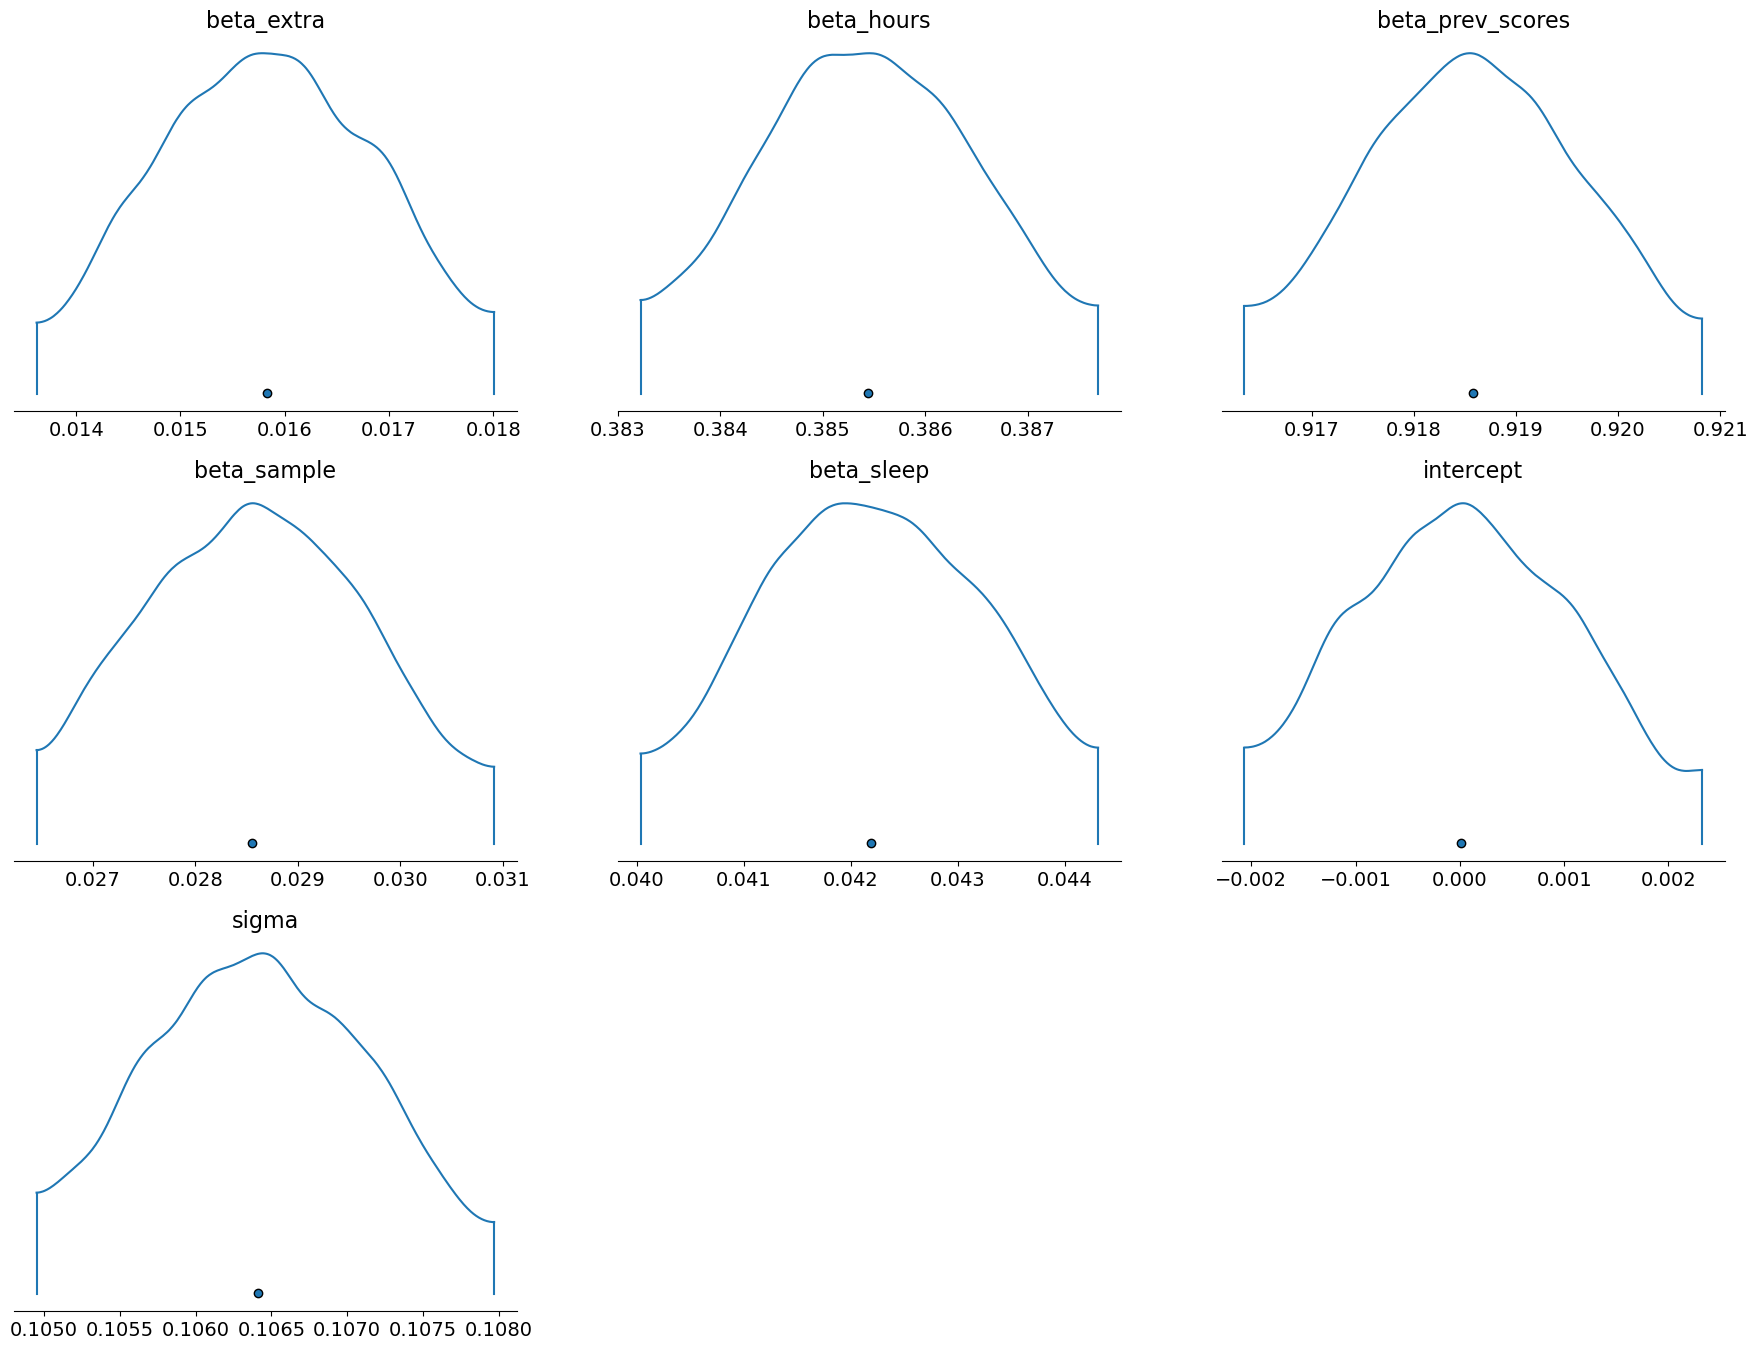

In [93]:
# Cumulative Distribution Function Plot
az.plot_density(trace);
plt.show();

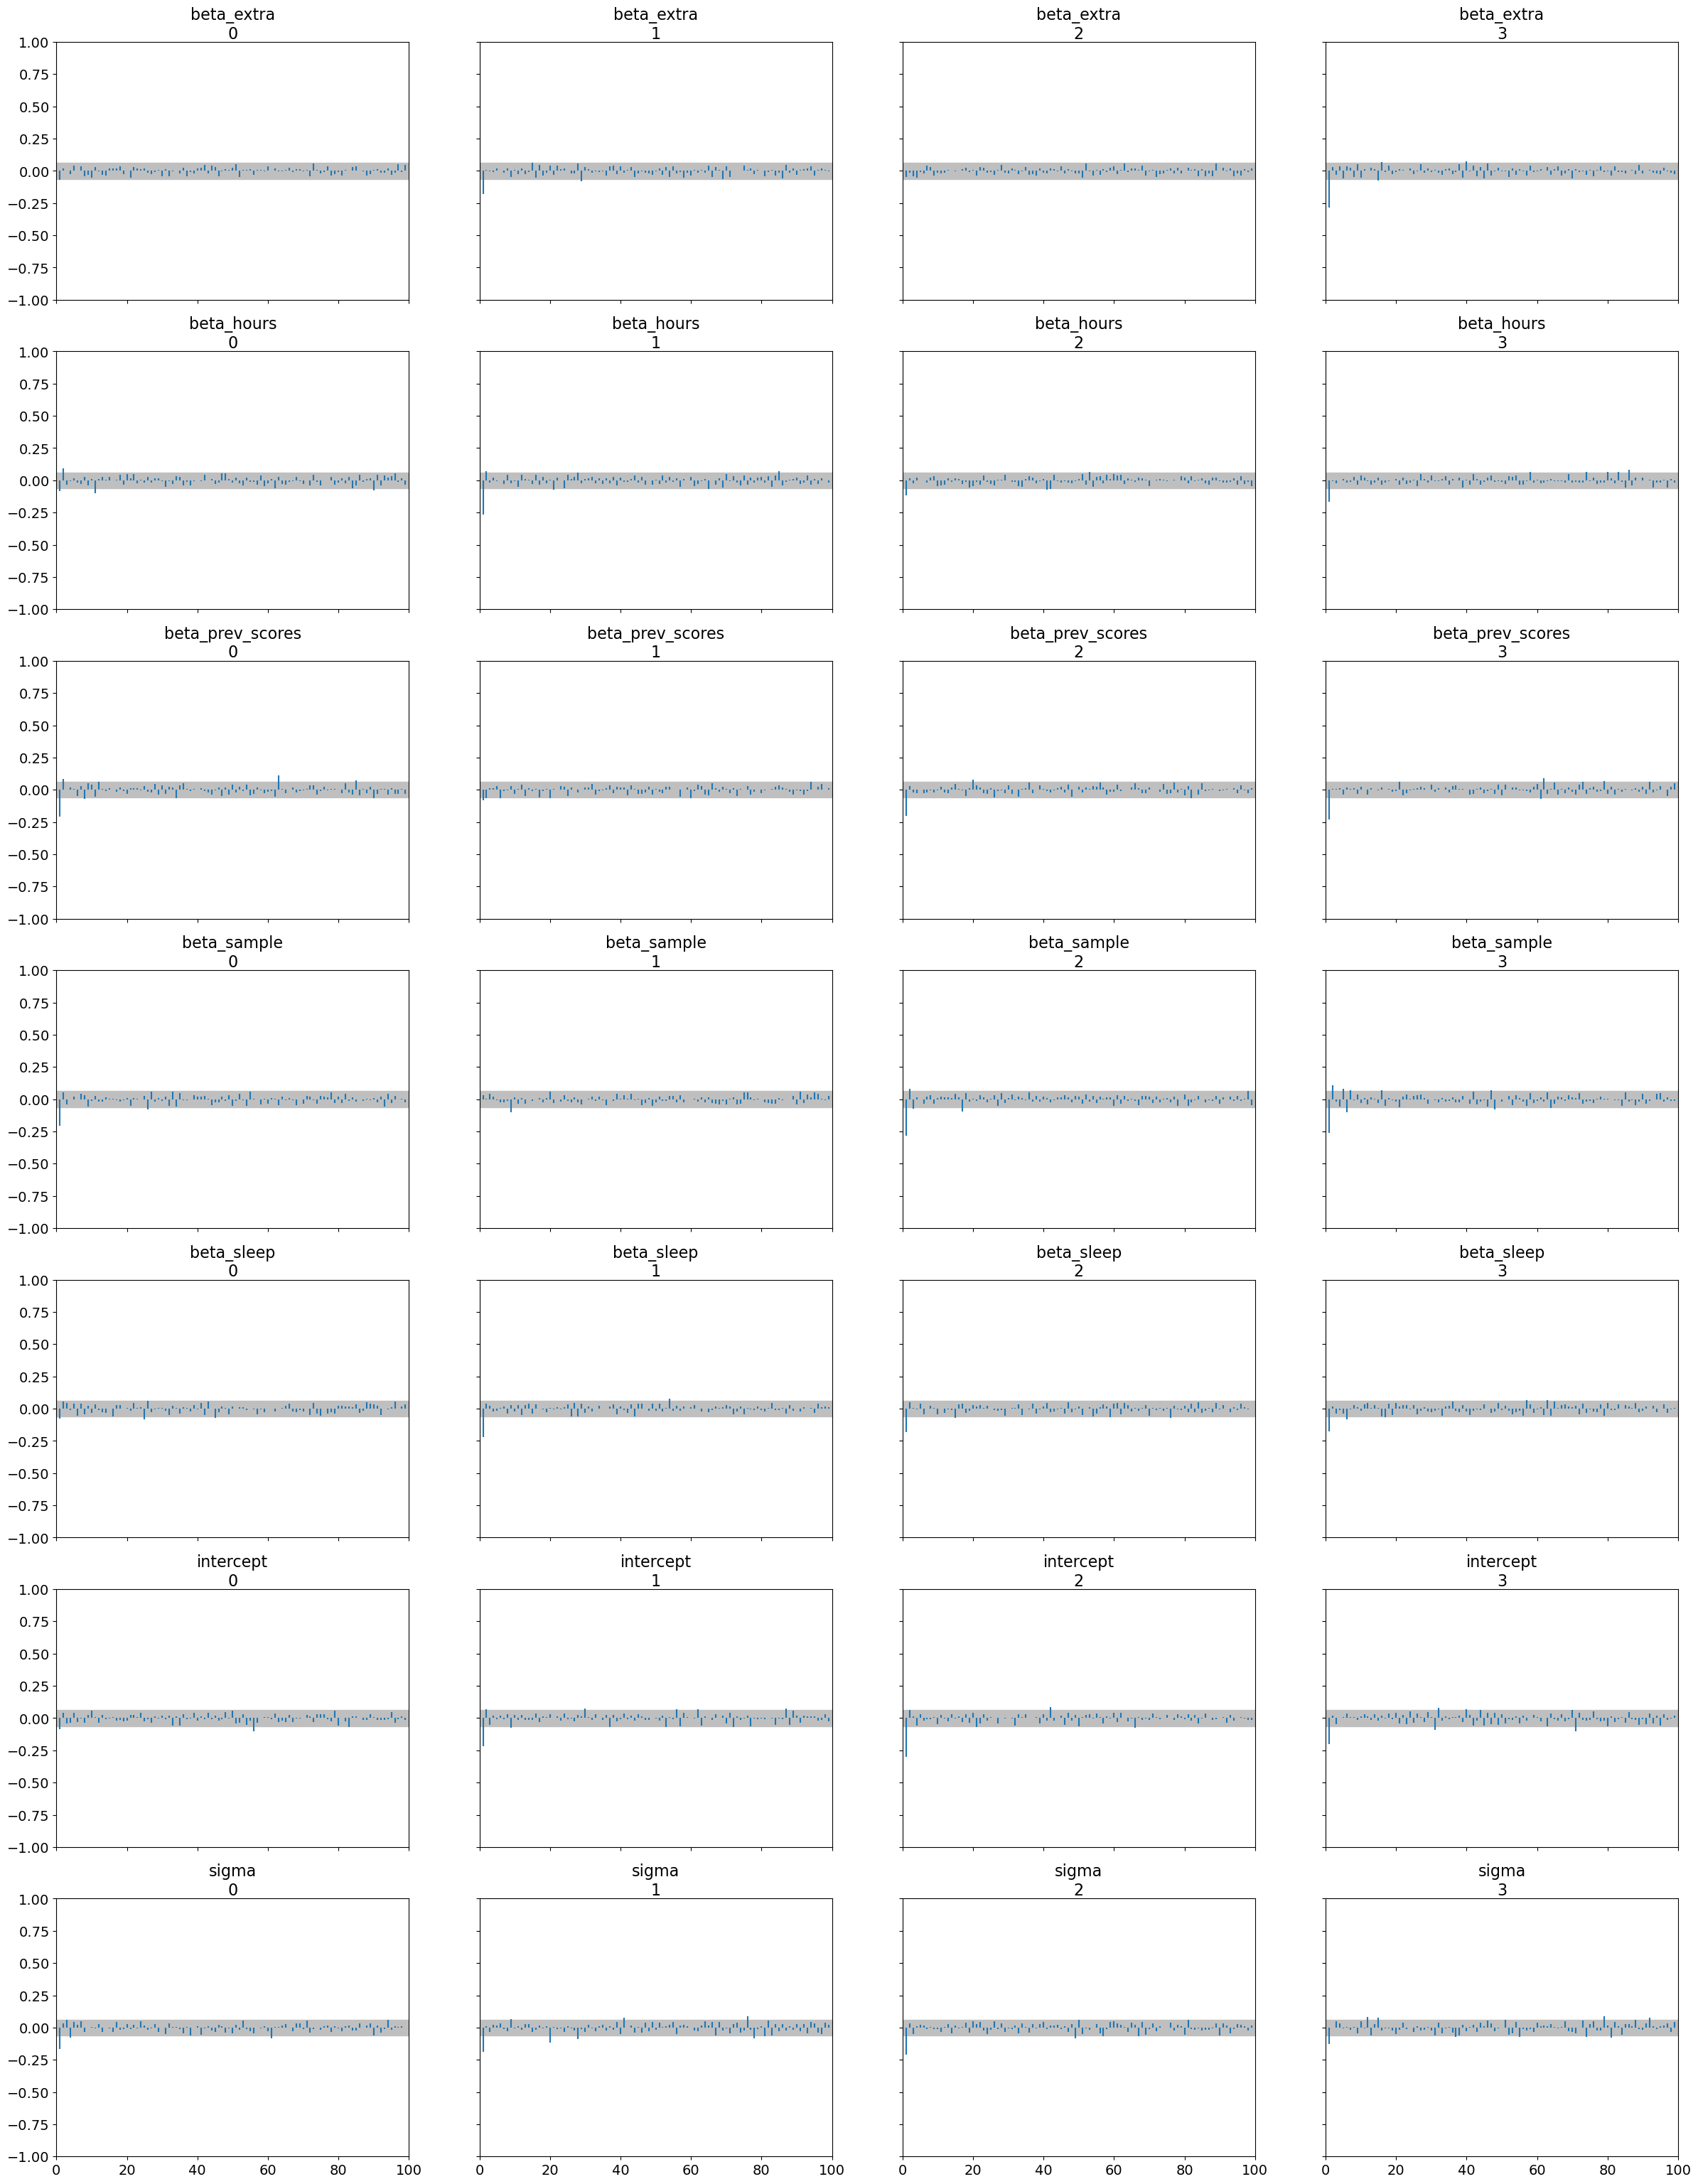

In [94]:
# Correlation Matrix of Parameters
az.plot_autocorr(trace)
plt.show()

## Test Model Performance

In [34]:
with pymc_pred_model:
    # When you want to switch to test data
    pm.set_data({
        'hours_studied': X_test_input['Hours Studied'].values,
        'prev_scores': X_test_input['Previous Scores'].values,
        'extra_activities': X_test_input['Extracurricular Activities'].values,
        'sleep_hours': X_test_input['Sleep Hours'].values,
        'sample_papers': X_test_input['Sample Question Papers Practiced'].values
    })
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [performance]


Output()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8000,) and arg 1 with shape (2000,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x161D790AA40>), [8000], 11, Composite{(i2 + (i9 * i10) + (i7 * i8) + (i5 * i6) + (i3 * i4) + (i0 * i1))}.0, sigma)
Toposort index: 7
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(None,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (2000,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x161D790AA40, array([8000], dtype=int64), array(11, dtype=int64), 'not shown', array(0.10554287)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
%%time
with pm.Model() as linear_model:

     # Define priors for intercept and coefficients (using sigma=1 because it's standardized)
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    beta_hours = pm.Normal("Beta_Hours_Studied", mu=0, sigma=1)
    beta_prev_scores = pm.Normal("Beta_Previous_Scores", mu=0, sigma=1)
    beta_extra = pm.Normal("Beta_Extracurricular_Activities", mu=0, sigma=1)
    beta_sleep = pm.Normal("Beta_Sleep_Hours", mu=0, sigma=1)
    beta_samples = pm.Normal("Beta_Sample_Questions", mu=0, sigma=1)


    # Linear regression model using normalized predictors
    mu = (intercept
        + beta_hours * X_normalized['Hours Studied']
        + beta_prev_scores * X_normalized['Previous Scores']
        + beta_extra * X_normalized['Extracurricular Activities']
        + beta_sleep * X_normalized['Sleep Hours']
        + beta_samples * X_normalized['Sample Question Papers Practiced']
        )

    # Beta distribution parameters (shape to be constrained to be >0)
    alpha = pm.Exponential("alpha", 1)
    beta = pm.Exponential("beta", 1)
    p = pm.Deterministic("p", pm.math.sigmoid(mu)) # Sigmoid to bound in (0,1)

    # Likelihood
    performance = pm.Beta("Performance Index", alpha=alpha * p, beta=beta * (1-p), observed=df['Performance Index Scaled'])

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array(-0.64701846), 'Beta_Hours_Studied': array(0.15043825), 'Beta_Previous_Scores': array(-0.99105162), 'Beta_Extracurricular_Activities': array(0.12194617), 'Beta_Sleep_Hours': array(-0.3851794), 'Beta_Sample_Questions': array(0.77326593), 'alpha_log__': array(-0.81497035), 'beta_log__': array(-0.77973953)}

Logp initial evaluation results:
{'Intercept': -1.13, 'Beta_Hours_Studied': -0.93, 'Beta_Previous_Scores': -1.41, 'Beta_Extracurricular_Activities': -0.93, 'Beta_Sleep_Hours': -0.99, 'Beta_Sample_Questions': -1.22, 'alpha': -1.26, 'beta': -1.24, 'Performance Index': inf}
You can call `model.debug()` for more details.

<br>

***

<Br>